In [1]:
import os
import re
import time
import numpy as np
from scipy import io
from tqdm import tqdm
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [12]:
OUTPUT_DIRS = {
    'waveforms': 'out/waveforms',
    'cache': 'out/'
}

N_SAMPLES = 240000
SAMPLING_RATE = 400
N_CHANNELS = 16

In [30]:
# make sure output dirs exist
for v in OUTPUT_DIRS.values(): 
    if not os.path.isdir(v): 
        os.makedirs(v)

In [15]:
def read_mat(f):
    mat = io.loadmat(f)
    
    sampling_rate = int(mat['dataStruct'][0, 0][1][0, 0])
    n_samples = int(mat['dataStruct'][0, 0][2][0, 0])
    ch_indexes = np.int8(mat['dataStruct'][0, 0][3][0])

    data = mat['dataStruct'][0, 0][0].T
    
    waves = np.zeros([len(ch_indexes), n_samples], dtype=np.float32)
    
    for i in range(len(ch_indexes)):
        waves[i] = data[ch_indexes[i] - 1]  
        
    return waves

In [22]:
input_df = pd.read_csv('out/input_files.csv', index_col='file')
all_paths = input_df['path'].tolist()

In [23]:
def compute_metrics(files=all_paths):
    n_waves = 0
    avg_wave = np.zeros(N_SAMPLES, dtype=np.float32)
    maxs = []
    mins = []

    for f in tqdm(files):
        n_waves += 1
        waves = read_mat(f)
        
        # mins/maxs
        maxs.append(np.max(waves, axis=1))
        mins.append(np.min(waves, axis=1))
        
        # mean, median
        
        # compute avg wave
        cur_avg_wave = np.divide(np.sum(waves, axis=0), len(waves))
        sum_all_waves = np.sum((np.multiply(avg_wave, n_waves - 1), cur_avg_wave), axis=0)
        avg_wave = np.divide(sum_all_waves, n_waves)
        
    return np.array(mins, dtype=np.float32),\
        np.array(maxs, dtype=np.float32),\
        avg_wave

In [24]:
metrics_file = OUTPUT_DIRS['cache'] + '/metrics.npy'

In [25]:
if not os.path.isfile(metrics_file):
    print 'Gathering metrics...'; time.sleep(0.5)
    mins, maxs, avg_wave = compute_metrics()
    np.save(OUTPUT_DIRS['cache'] + '/metrics.npy', {'mins': mins, 'maxs': maxs, 'avg': avg_wave})

Gathering metrics...


100%|██████████| 6672/6672 [09:07<00:00, 14.11it/s]


In [26]:
metrics = np.load(metrics_file).item()

# compute thresholds for 99% of mins/maxs
max_threshold = np.percentile(metrics['maxs'], 99)
min_threshold = -np.percentile(np.abs(metrics['mins']), 99)
avg_wave = metrics['avg']

In [ ]:
# process waveforms

print 'Processing waveforms...'; time.sleep(0.5)

scale_factor = max(max_threshold, abs(min_threshold))

for f in tqdm(all_paths):
    fid = re.findall(r'[^/]+\.mat$', f)[0]
    waves = read_mat(f)

    # subtract mean
    waves = np.subtract(waves, avg_wave)
    # clip
    waves = np.clip(waves, min_threshold, max_threshold)
    # scale
    waves = np.divide(waves, scale_factor)
    
    # save
    out_f = OUTPUT_DIRS['waveforms'] + '/' + fid + '.mem'
    waves.tofile(out_f)

Processing waveforms...


 87%|████████▋ | 5834/6672 [09:34<01:32,  9.04it/s]

In [32]:
f

'/datasets/kaggle/mls/train_3/3_1726_0.mat'

In [33]:
out_f

'out/waveforms/3_1726_0.mat.mem'

In [34]:
w = np.fromfile('out/waveforms/3_1726_0.mat.mem', dtype=np.float32).reshape(16,-1)

In [35]:
w.shape

(16, 240000)

In [39]:
4800*w.size*4./pow(2,30)

68.66455078125

In [40]:
def read_waves(fid):
    return np.fromfile(OUTPUT_DIRS['waveforms'] + '/' + fid + '.mem', \
                       dtype=np.float32).reshape(N_CHANNELS, -1)

In [43]:
ww = read_waves('3_1726_0.mat')

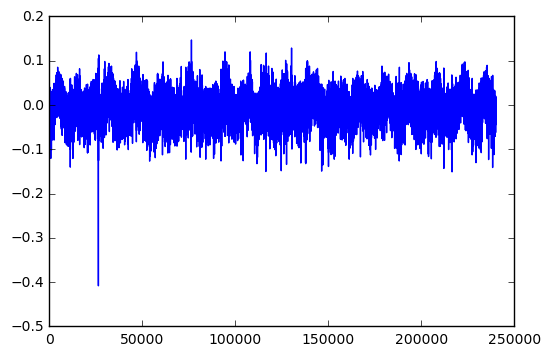

In [47]:
plt.plot(ww[3])